# Deep Ensemble (Toy)
This example shows how to use deep ensembles with PusH on a toy regression dataset.

In [1]:
# Set a seed for reproducibility
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])

In [2]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [3]:
import push.bayes.ensemble
# Combine X and Y into a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
epochs=3000
lr = 0.03
# ensemble = push.bayes.ensemble.train_deep_ensemble(
#         train_loader,
#         torch.nn.MSELoss(),
#         epochs,
#         GenericNet, 1,
#         lr=lr,
#         num_devices=2,
#         num_ensembles=num_ensembles,
#         bootstrap=False
#     )
ensemble_sizes = [2, 4, 8, 16]
num_devices = 2
# Dictionary to store the trained models for each ensemble size
trained_ensembles = {}

# Train an ensemble for each size specified
for size in ensemble_sizes:
    print(f"Training ensemble with {size} models...")
    ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        GenericNet, 1,
        lr=lr,
        num_devices=num_devices,
        num_ensembles=size,
        bootstrap=False
    )
    trained_ensembles[size] = ensemble
    print(f"Completed training for ensemble size {size}.")

Training ensemble with 2 models...


100%|██████████| 3000/3000 [00:31<00:00, 95.07it/s, loss=tensor(0.0025)] 


Completed training for ensemble size 2.
Training ensemble with 4 models...


100%|██████████| 3000/3000 [00:45<00:00, 66.02it/s, loss=tensor(0.0025)]


Completed training for ensemble size 4.
Training ensemble with 8 models...


100%|██████████| 3000/3000 [01:15<00:00, 39.63it/s, loss=tensor(0.0025)]


Completed training for ensemble size 8.
Training ensemble with 16 models...


100%|██████████| 3000/3000 [05:02<00:00,  9.90it/s, loss=tensor(0.0024)]

Completed training for ensemble size 16.


In [14]:
def get_ensemble_outputs(ensembles, x_grid):
    """
    Get predictions, means, and standard deviations from multiple ensembles.
    
    Parameters:
        ensembles (dict): A dictionary of ensembles keyed by the number of models.
        x_grid (torch.Tensor): The input tensor for which predictions are made.
    
    Returns:
        dict: A dictionary containing predictions, means, and std for each ensemble size.
    """
    results = {}
    for size, ensemble in ensembles.items():
        output = ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
        results[size] = {
            'mean': output["mean"],  # Assuming the mean is the first element
            'std': output["std"],   # Assuming the std is the second element
            'pred': output["pred"]  # Assuming the predictions are the third element
        }
        # print(f"Output for ensemble size {size}: Mean shape {output["mean"].shape}, STD shape {output["shape"].shape}")
    return results

outputs = get_ensemble_outputs(trained_ensembles, x_grid)

In [4]:
ensemble_output = ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])

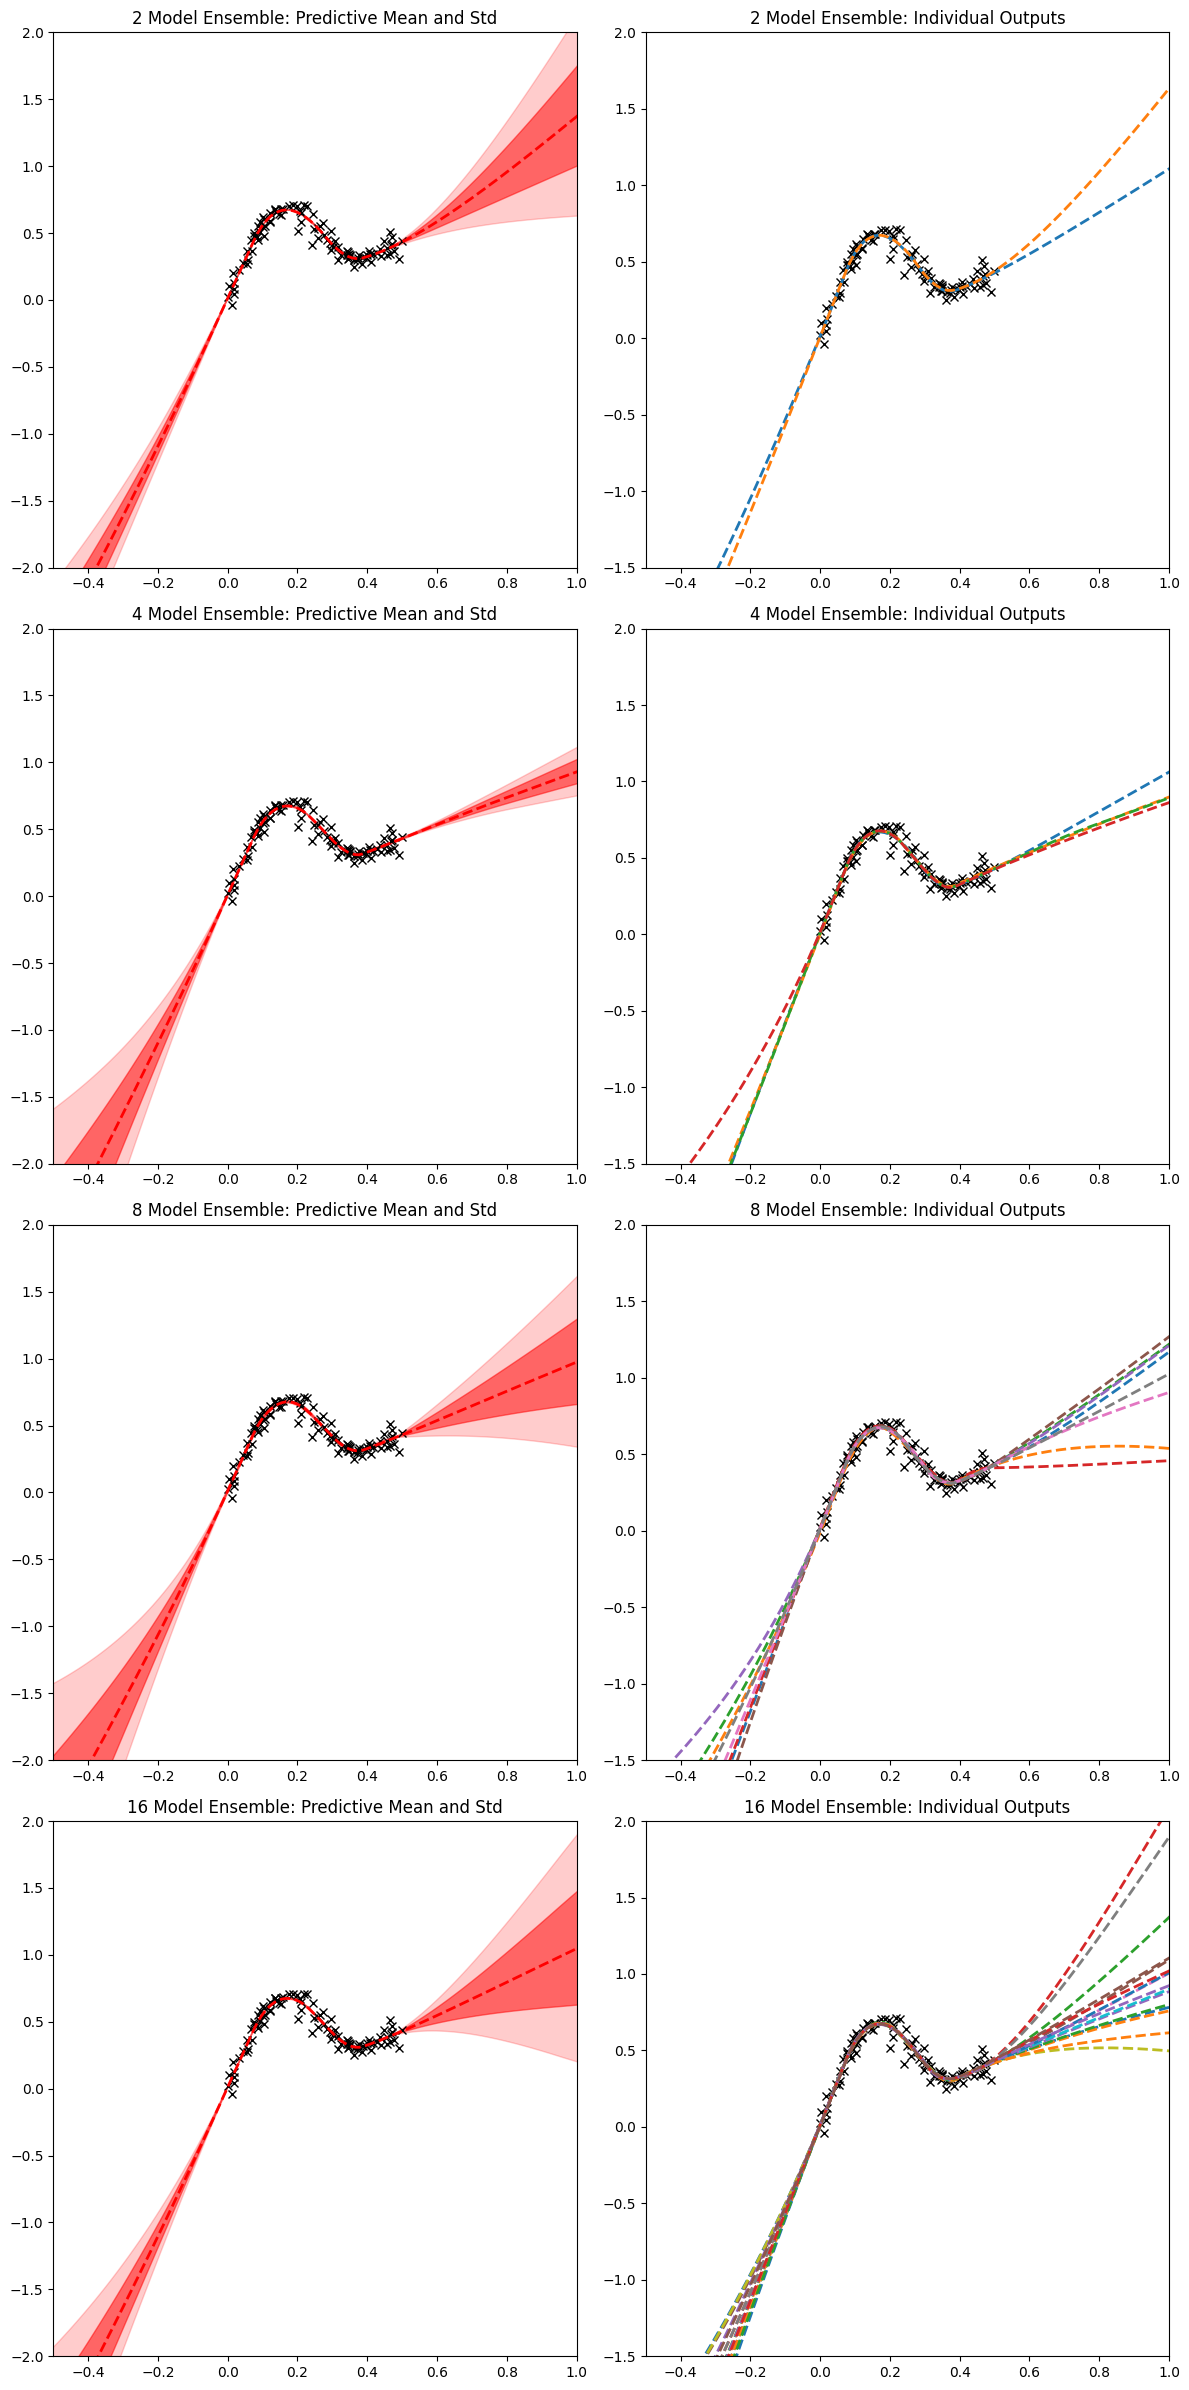

In [21]:
import matplotlib.pyplot as plt
import torch

def plot_all_toys(outputs, x_grid, X, Y):
    # Create a figure with 4 rows (one for each ensemble size) and 2 columns
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=[12, 24])

    for i, (num_models, data) in enumerate(outputs.items()):
        # Predictive mean and std (first column of each row)
        axs[i, 0].plot(X, Y, "kx", label="Toy data", markersize=6)
        axs[i, 0].set_xlim(-0.5, 1)
        axs[i, 0].set_ylim(-2, 2)
        axs[i, 0].plot(x_grid, data["mean"], "r--", linewidth=2)
        axs[i, 0].fill_between(x_grid.squeeze(), (data["mean"] - data["std"]).squeeze(), (data["mean"] + data["std"]).squeeze(), alpha=0.5, color="red")
        axs[i, 0].fill_between(
            x_grid.squeeze(), (data["mean"] - 2 * data["std"]).squeeze(), (data["mean"] + 2 * data["std"]).squeeze(), alpha=0.2, color="red"
        )
        axs[i, 0].set_title(f"{num_models} Model Ensemble: Predictive Mean and Std")

        # Individual model outputs (second column of each row)
        axs[i, 1].plot(X, Y, "kx", label="Toy data", markersize=6)
        axs[i, 1].set_xlim(-0.5, 1)
        axs[i, 1].set_ylim(-1.5, 2)
        for j in range(num_models):
            axs[i, 1].plot(x_grid, torch.tensor([sublist[j] for sublist in data["pred"]]), linestyle="--", linewidth=2)
        axs[i, 1].set_title(f"{num_models} Model Ensemble: Individual Outputs")

    plt.tight_layout()
    plt.show()

# Example usage
plot_all_toys({
    2: outputs[2],
    4: outputs[4],
    8: outputs[8],
    16: outputs[16]
}, x_grid, X, Y)
